# BA820 - M2: Core vs. Specialty Colors in Bob Ross Paintings

**Student:** Anton Falk  
**Section:** A1 - Team M2  
**Date:** February 2026

---

## What Changed from M1

Our last M1 question was about figuring out which colors are "core" vs "specialty" based on the big gap in usage rates (Indian Red at 0.2% vs Titanium White at 99.3%).

I kept my core vs specialty question but added two things on top of it: theme tags from the painting titles (winter, mountain, water, etc.) to see if color groupings depend on subject matter, and an early vs late season comparison to check if the "core" set is actually stable over time or if it shifts.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=17d9X4zUbU4uPD_oEqb0hlnMexbjZcpeR')

color_cols = [c for c in df.columns if df[c].dtype == bool]
print(f"Dataset: {df.shape[0]} paintings, {len(color_cols)} colors")
df.info()

Dataset: 403 paintings, 18 colors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-nu

In [3]:
df.head()

,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


## 2. EDA & Preprocessing

M1 covered the basic EDA. Here I'm looking more closely at the usage distribution before clustering, and adding theme tags from the painting titles.

In [4]:
df.isna().sum()

,0
painting_index,0
img_src,0
painting_title,0
season,0
episode,0
num_colors,0
youtube_src,0
colors,0
color_hex,0
Black_Gesso,0


In [5]:
# Color usage rates
color_usage = df[color_cols].sum().sort_values(ascending=False)
color_pct = (color_usage / len(df) * 100).round(1)

print("Color Usage:")
for color, pct in color_pct.items():
    print(f"- {color}: {pct}%")

Color Usage:
- Titanium_White: 99.3%
- Alizarin_Crimson: 94.3%
- Van_Dyke_Brown: 92.1%
- Cadmium_Yellow: 85.9%
- Yellow_Ochre: 81.1%
- Phthalo_Blue: 80.1%
- Bright_Red: 79.7%
- Midnight_Black: 78.7%
- Sap_Green: 75.9%
- Indian_Yellow: 72.5%
- Dark_Sienna: 72.0%
- Prussian_Blue: 65.3%
- Phthalo_Green: 28.8%
- Black_Gesso: 25.1%
- Burnt_Umber: 13.6%
- Liquid_Clear: 12.7%
- Liquid_Black: 3.5%
- Indian_Red: 0.2%


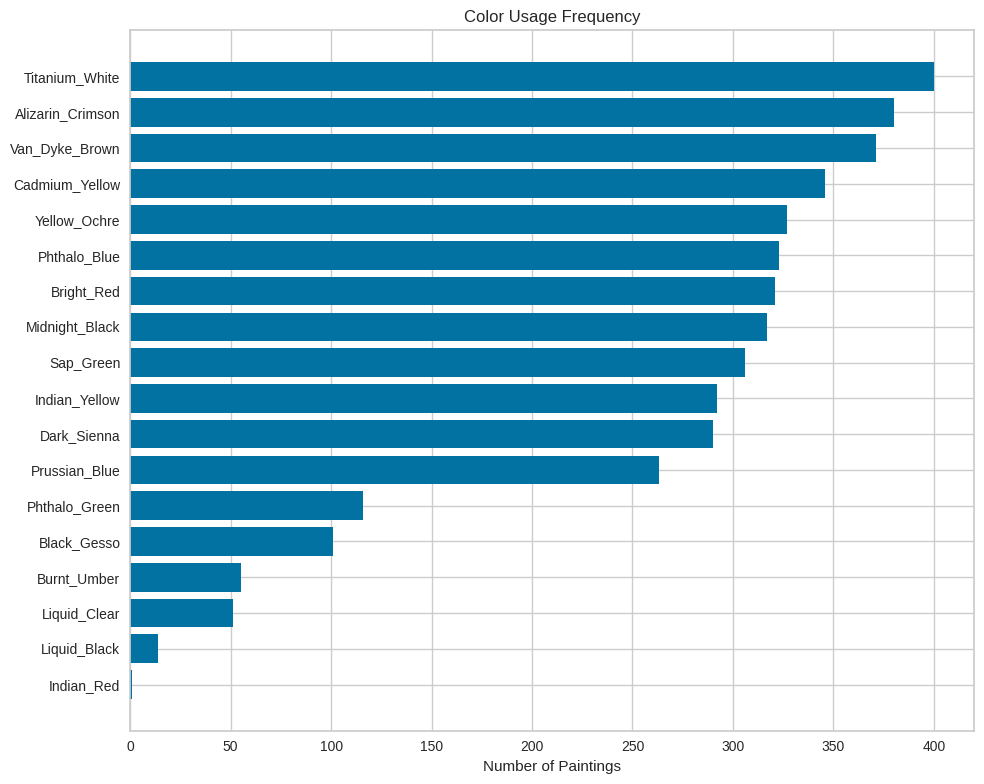

In [6]:
# Visualize usage
plt.figure(figsize=(10, 8))
colors_sorted = color_usage.sort_values()
plt.barh(range(len(colors_sorted)), colors_sorted.values)
plt.yticks(range(len(colors_sorted)), [c for c in colors_sorted.index])
plt.xlabel('Number of Paintings')
plt.title('Color Usage Frequency')
plt.tight_layout()
plt.show()

There is a gap between the colors above ~60% and the ones below ~35%.

### 2.1 Feature Engineering: Title-Based Theme Tags

The M1 feedback asked us to incorporate text features. The painting titles contain keywords that hint at the subject matter ("winter," "mountain," "lake," etc.). Creating simple theme tags from them.

In [7]:
# Theme keywords (similar to what Jesse used for Q1)
theme_keywords = {
    "winter": ["winter", "snow", "frost", "cold", "ice", "frozen"],
    "mountain": ["mountain", "mountains", "peak", "summit", "ridge"],
    "water": ["lake", "river", "stream", "ocean", "sea", "waterfall", "pond", "creek", "falls"],
    "cabin": ["cabin", "barn", "house", "cottage", "mill"],
    "sunset": ["sunset", "sunrise", "dawn", "dusk", "evening"]
}

def assign_themes(title):
    title = title.lower()
    tags = {}
    for theme, keywords in theme_keywords.items():
        tags[f"theme_{theme}"] = any(word in title for word in keywords)
    return tags

theme_df = pd.DataFrame(df['painting_title'].apply(assign_themes).tolist())
df = pd.concat([df, theme_df], axis=1)

theme_cols = [c for c in df.columns if c.startswith('theme_')]
print("Theme counts:")
for col in theme_cols:
    count = df[col].sum()
    print(f"  {col}: {count} paintings ({round(count/len(df)*100, 1)}%)")

Theme counts:
  theme_winter: 56 paintings (13.9%)
  theme_mountain: 62 paintings (15.4%)
  theme_water: 86 paintings (21.3%)
  theme_cabin: 28 paintings (6.9%)
  theme_sunset: 23 paintings (5.7%)


### 2.2 Correlation Heatmap

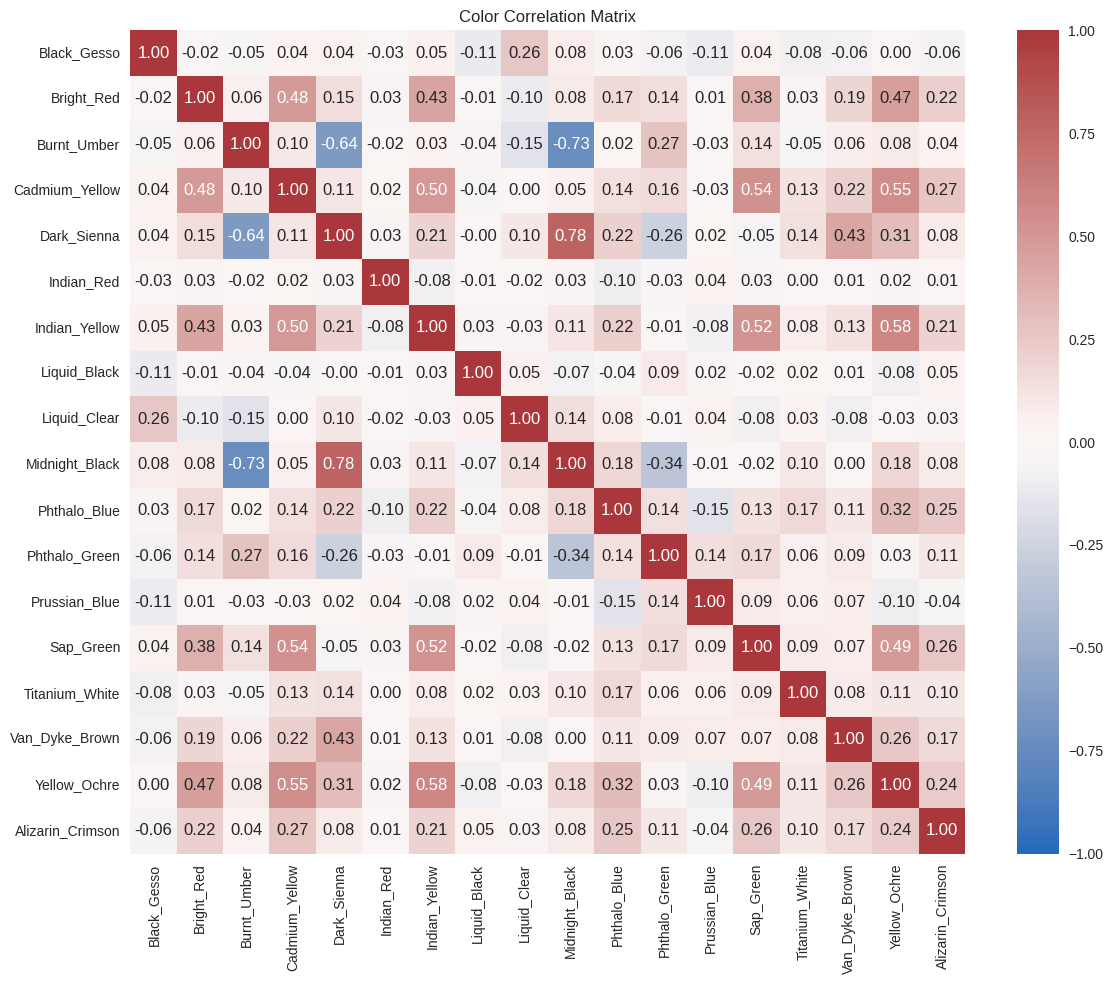

In [8]:
color_corr = df[color_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(color_corr, annot=True, fmt='.2f', cmap='vlag', center=0, vmin=-1, vmax=1)
plt.title('Color Correlation Matrix')
plt.tight_layout()
plt.show()

Same patterns as M1: Dark Sienna and Midnight Black correlate strongly (~0.78), Burnt Umber is negatively correlated with both.

## 3. Analysis 1: Clustering the Colors

I wanted to cluster the 18 colors themselves instead of clustering paintings. To do that I transposed the data so each row is a color and each column is a painting. Colors that show up in similar paintings should cluster together.

I got the transpose idea from AI (see appendix). The clustering code is the same approach as the housing market example from class.

### 3.1 Without Normalization First

In the housing data example, clustering without normalization was dominated by population because of scale differences. Same idea here, want to see the effect.

In [9]:
# Transpose: rows = colors, columns = paintings
color_matrix = df[color_cols].T.astype(int)
color_matrix.index.name = 'color'
print(f"Shape: {color_matrix.shape}")
color_matrix.head()

Shape: (18, 403)


,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
color,,,,,,,,,,,,,,,,,,,,,
Black_Gesso,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
Bright_Red,1,1,1,0,1,0,1,1,1,1,...,1,0,1,1,0,1,1,1,0,1
Burnt_Umber,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cadmium_Yellow,1,1,1,0,1,0,1,1,1,1,...,1,0,1,1,0,1,1,1,0,1
Dark_Sienna,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


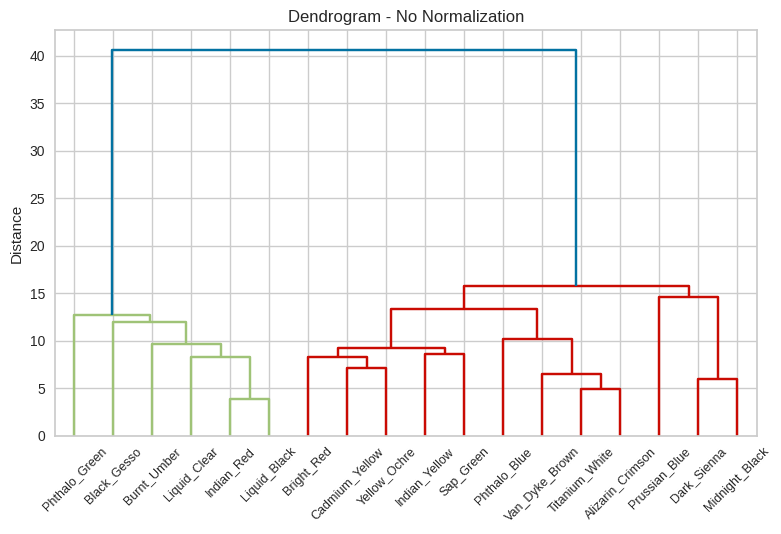

In [10]:
# Hierarchical clustering WITHOUT normalization
Z_raw = linkage(color_matrix, 'ward')

dendrogram(Z_raw, labels=color_matrix.index.tolist(), leaf_rotation=45, leaf_font_size=9)
plt.title('Dendrogram - No Normalization')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Visually looks like 3 groups based on the distance gaps.

In [11]:
# Cut based on dendrogram
dendro_clusters_raw = 3

In [12]:
color_matrix['cluster_labels'] = fcluster(Z_raw, dendro_clusters_raw, criterion='maxclust').astype(str)

color_matrix['cluster_labels'].value_counts()

,count
cluster_labels,
2,9
1,6
3,3


In [13]:
# What ended up in each cluster?
for label in sorted(color_matrix['cluster_labels'].unique()):
    colors_in = color_matrix[color_matrix['cluster_labels'] == label].index.tolist()
    print(f"\nCluster {label}:")
    for c in colors_in:
        print(f"  {c} - usage: {round(df[c].mean()*100, 1)}%")


Cluster 1:
  Black_Gesso - usage: 25.1%
  Burnt_Umber - usage: 13.6%
  Indian_Red - usage: 0.2%
  Liquid_Black - usage: 3.5%
  Liquid_Clear - usage: 12.7%
  Phthalo_Green - usage: 28.8%

Cluster 2:
  Bright_Red - usage: 79.7%
  Cadmium_Yellow - usage: 85.9%
  Indian_Yellow - usage: 72.5%
  Phthalo_Blue - usage: 80.1%
  Sap_Green - usage: 75.9%
  Titanium_White - usage: 99.3%
  Van_Dyke_Brown - usage: 92.1%
  Yellow_Ochre - usage: 81.1%
  Alizarin_Crimson - usage: 94.3%

Cluster 3:
  Dark_Sienna - usage: 72.0%
  Midnight_Black - usage: 78.7%
  Prussian_Blue - usage: 65.3%


Without normalization the clusters are basically just grouping by raw frequency. High usage in one cluster, medium in another, low in the third. That's not telling us anything we didn't already know from the bar chart. Similar to the housing example where one dominant feature drove the clustering

### 3.2 With Normalization

In [14]:
# Normalize
sc = StandardScaler()
color_matrix_normalized = color_matrix.drop('cluster_labels', axis=1)
color_matrix_normalized = pd.DataFrame(
    sc.fit_transform(color_matrix_normalized),
    columns=color_matrix_normalized.columns,
    index=color_matrix_normalized.index
)

color_matrix_normalized

,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
color,,,,,,,,,,,,,,,,,,,,,
Black_Gesso,-0.894427,-0.894427,1.0,-0.447214,-0.894427,1.870829,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,0.894427,-1.870829,0.620174,-1.414214,-0.797724,0.707107
Bright_Red,1.118034,1.118034,1.0,-0.447214,1.118034,-0.534522,1.118034,1.118034,1.118034,1.118034,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Burnt_Umber,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,-1.870829,-1.612452,-1.414214,-0.797724,-1.414214
Cadmium_Yellow,1.118034,1.118034,1.0,-0.447214,1.118034,-0.534522,1.118034,1.118034,1.118034,1.118034,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Dark_Sienna,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,0.797724,1.253566,0.620174,0.797724,0.894427,0.534522,0.620174,0.707107,1.253566,0.707107
Indian_Red,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,-1.870829,-1.612452,-1.414214,-0.797724,-1.414214
Indian_Yellow,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Liquid_Black,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,0.534522,-1.612452,-1.414214,-0.797724,-1.414214
Liquid_Clear,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,0.894427,-1.870829,0.620174,-1.414214,-0.797724,-1.414214


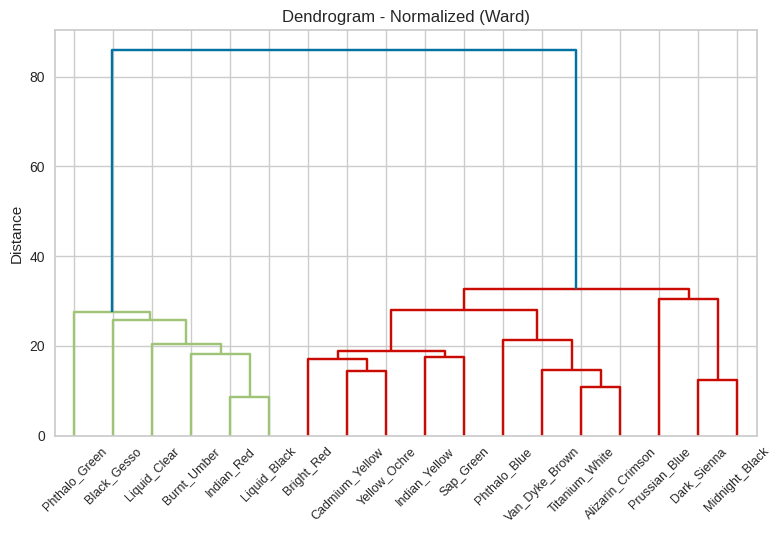

In [15]:
# Dendrogram on normalized data
Z = linkage(color_matrix_normalized, 'ward')

dendrogram(Z, labels=color_matrix_normalized.index.tolist(), leaf_rotation=45, leaf_font_size=9)
plt.title('Dendrogram - Normalized (Ward)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Dendrogram looks like there could be 3 or 4 groups.

### 3.3 Choosing K

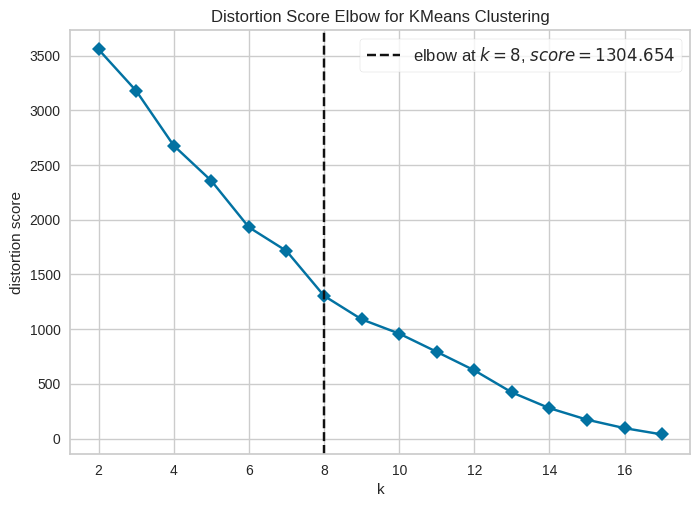

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# Elbow method
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 18), metric='distortion', timings=False, random_state=42
)

visualizer.fit(color_matrix_normalized)
visualizer.show()

Elbow shows the bend around K=8. With 18 colors total, 8 clusters means finer groupings beyond just high/medium/low which should give us more interesting separation.

In [17]:
# Alter this cell to change the number of clusters
n_clusters_kmeans = 8

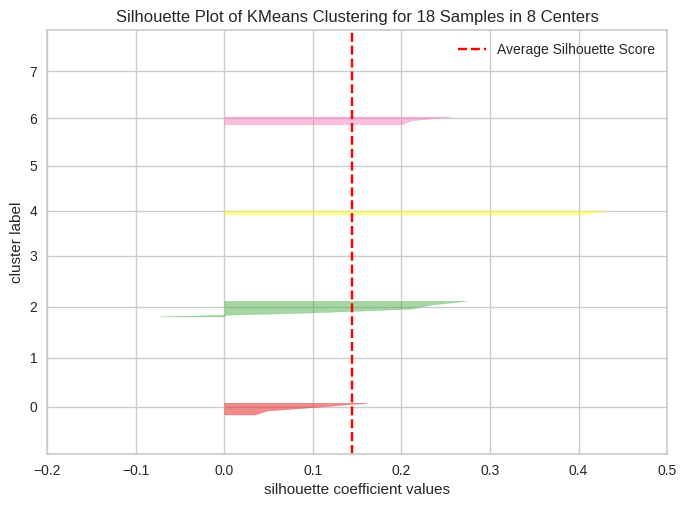

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
# Silhouette plot
kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(color_matrix_normalized)
visualizer.show()

K=8 gives us reasonably shaped clusters in the silhouette plot. Some are thinner than others but that makes sense since certain colors like Indian Red barely show up so they'll end up isolated.

### 3.4 K-Means Results

In [19]:
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)

color_matrix_normalized['cluster_labels'] = kmeans.fit_predict(color_matrix_normalized).astype(str)

print(color_matrix_normalized['cluster_labels'].value_counts())

cluster_labels
2    5
0    4
6    3
4    2
1    1
3    1
5    1
7    1
Name: count, dtype: int64


In [20]:
for label in sorted(color_matrix_normalized['cluster_labels'].unique()):
    colors_in = color_matrix_normalized[color_matrix_normalized['cluster_labels'] == label].index.tolist()
    print(f"\nCluster {label}:")
    for c in colors_in:
        print(f"  {c}: {round(df[c].mean()*100, 1)}%")


Cluster 0:
  Bright_Red: 79.7%
  Indian_Yellow: 72.5%
  Sap_Green: 75.9%
  Yellow_Ochre: 81.1%

Cluster 1:
  Burnt_Umber: 13.6%

Cluster 2:
  Cadmium_Yellow: 85.9%
  Phthalo_Blue: 80.1%
  Titanium_White: 99.3%
  Van_Dyke_Brown: 92.1%
  Alizarin_Crimson: 94.3%

Cluster 3:
  Black_Gesso: 25.1%

Cluster 4:
  Dark_Sienna: 72.0%
  Midnight_Black: 78.7%

Cluster 5:
  Phthalo_Green: 28.8%

Cluster 6:
  Indian_Red: 0.2%
  Liquid_Black: 3.5%
  Liquid_Clear: 12.7%

Cluster 7:
  Prussian_Blue: 65.3%


In [21]:
cluster_info = pd.DataFrame({
    'color': color_matrix_normalized.index,
    'usage_rate': [df[c].mean() for c in color_matrix_normalized.index],
    'cluster_labels': color_matrix_normalized['cluster_labels'].values
})

# Summary stats per cluster
cluster_summary = cluster_info.groupby('cluster_labels').agg(
    n_colors=('color', 'count'),
    avg_usage=('usage_rate', 'mean'),
    min_usage=('usage_rate', 'min'),
    max_usage=('usage_rate', 'max')
).round(3)

cluster_summary

,n_colors,avg_usage,min_usage,max_usage
cluster_labels,,,,
0,4,0.773,0.725,0.811
1,1,0.136,0.136,0.136
2,5,0.903,0.801,0.993
3,1,0.251,0.251,0.251
4,2,0.753,0.720,0.787
5,1,0.288,0.288,0.288
6,3,0.055,0.002,0.127
7,1,0.653,0.653,0.653


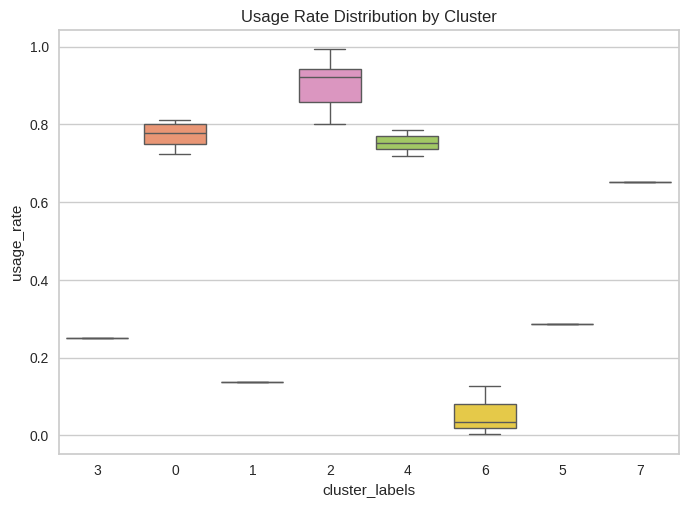

In [22]:
sns.boxplot(data=cluster_info, x='cluster_labels', y='usage_rate', palette='Set2')
plt.title('Usage Rate Distribution by Cluster')
plt.show()

With K=8 the boxplot shows clusters at different usage levels. Some only have 1-2 colors in them which could mean those colors don't co-occur with much else.

### 3.5 Connecting Clusters to Themes

In [23]:
# Which themes tend to use which cluster's colors?
for label in sorted(color_matrix_normalized['cluster_labels'].unique()):
    cluster_colors = color_matrix_normalized[color_matrix_normalized['cluster_labels'] == label].index.tolist()
    print(f"\nCluster {label} colors: {', '.join(cluster_colors)}")
    for theme in [c for c in df.columns if c.startswith('theme_')]:
        themed = df[df[theme]]
        if len(themed) > 0:
            avg_usage = themed[cluster_colors].mean().mean()
            print(f"  {theme}: avg usage {round(avg_usage*100, 1)}%")


Cluster 0 colors: Bright_Red, Indian_Yellow, Sap_Green, Yellow_Ochre
  theme_winter: avg usage 32.6%
  theme_mountain: avg usage 87.5%
  theme_water: avg usage 88.7%
  theme_cabin: avg usage 75.9%
  theme_sunset: avg usage 71.7%

Cluster 1 colors: Burnt_Umber
  theme_winter: avg usage 7.1%
  theme_mountain: avg usage 9.7%
  theme_water: avg usage 16.3%
  theme_cabin: avg usage 14.3%
  theme_sunset: avg usage 4.3%

Cluster 2 colors: Cadmium_Yellow, Phthalo_Blue, Titanium_White, Van_Dyke_Brown, Alizarin_Crimson
  theme_winter: avg usage 75.4%
  theme_mountain: avg usage 95.8%
  theme_water: avg usage 95.1%
  theme_cabin: avg usage 87.9%
  theme_sunset: avg usage 87.8%

Cluster 3 colors: Black_Gesso
  theme_winter: avg usage 10.7%
  theme_mountain: avg usage 9.7%
  theme_water: avg usage 40.7%
  theme_cabin: avg usage 14.3%
  theme_sunset: avg usage 43.5%

Cluster 4 colors: Dark_Sienna, Midnight_Black
  theme_winter: avg usage 73.2%
  theme_mountain: avg usage 79.8%
  theme_water: avg us

High-usage clusters have similar averages across all themes since those colors show up everywhere. The lower-usage ones vary more by theme.

## 4. PCA

Running PCA on the color data to see which colors contribute the most variance across paintings.

In [24]:
# PCA on paintings x colors (normalized)
color_data = df[color_cols].astype(int)

sc_pca = StandardScaler()
color_data_normalized = pd.DataFrame(
    sc_pca.fit_transform(color_data),
    columns=color_cols
)

# Fit PCA
model = PCA()
model.fit(color_data_normalized)

PCA()

In [25]:
model.explained_variance_ratio_

array([0.19501853, 0.14820956, 0.07736252, 0.06992952, 0.06505021,
       0.05798786, 0.0553138 , 0.05434888, 0.04723251, 0.04274317,
       0.03821608, 0.03595799, 0.03142742, 0.02314969, 0.02102074,
       0.02007406, 0.01185288, 0.00510458])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.7/458.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.8 MB/s eta 0:00:00


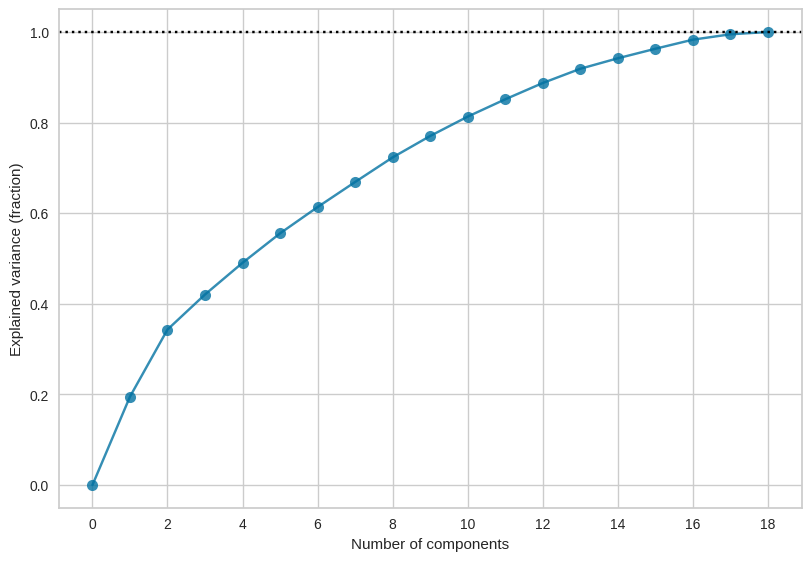

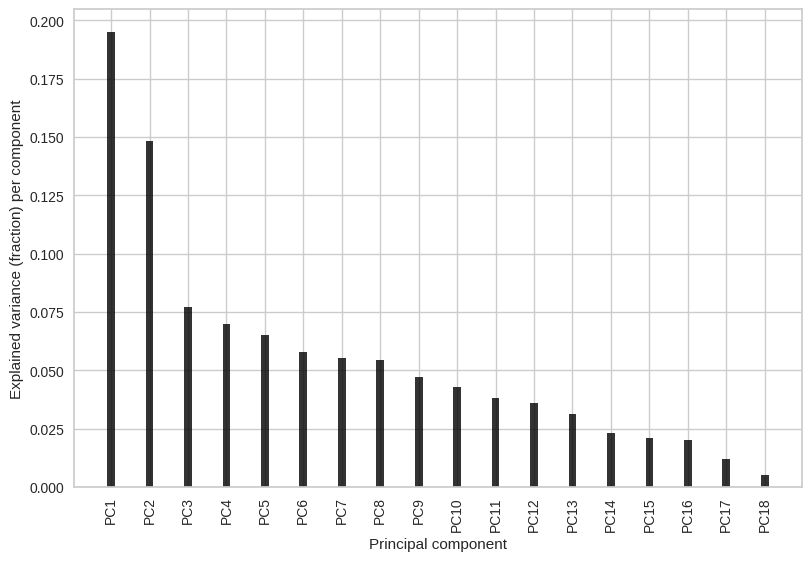

In [26]:
# Scree plot using psynlig (same as class)
!pip install psynlig -q

from psynlig import pca_explained_variance, pca_explained_variance_bar

_, ax = pca_explained_variance(model, marker='o', markersize=8, alpha=0.8)
plt.show()

pca_explained_variance_bar(model, width=0.2, alpha=0.8, color='black')
plt.show()

Variance is spread pretty evenly since each color is binary and mostly independent from the others.

In [27]:
components_df = pd.DataFrame(
    model.components_[:10],
    index=[f'PC{j+1}' for j in range(10)],
    columns=color_cols
)

components_df

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
PC1,0.015501,0.351627,-0.037512,0.393587,0.245254,-0.000497,0.393278,-0.021465,-0.006999,0.175639,0.230519,0.047792,-0.026181,0.343003,0.119417,0.207165,0.430855,0.238857
PC2,0.079658,-0.110622,-0.515910,-0.149295,0.483594,0.019163,-0.070101,-0.022641,0.155015,0.521245,0.036496,-0.317818,-0.019597,-0.216132,0.043630,0.022578,-0.046876,-0.059449
PC3,0.563191,-0.035418,0.057736,0.058206,-0.180369,-0.152758,0.166286,-0.244134,0.289973,0.007161,0.088244,-0.199130,-0.409559,0.089088,-0.238635,-0.391632,0.082074,-0.086087
PC4,0.127479,-0.159060,0.031711,-0.076385,-0.006349,-0.272616,-0.127723,0.226837,0.472677,-0.034310,0.465192,0.380451,0.014889,-0.121653,0.346344,0.028015,-0.105803,0.277091
PC5,0.271925,0.062458,-0.142258,0.166420,-0.044732,0.255142,0.020032,0.142549,0.424666,0.034791,-0.369260,0.157743,0.583859,0.256135,-0.030464,-0.146737,-0.074209,-0.095664
PC6,-0.293312,0.046411,-0.189436,-0.009443,-0.120736,-0.206002,0.225203,0.672545,-0.075595,0.085359,-0.077843,-0.108681,-0.146827,0.134969,-0.032297,-0.484248,-0.044166,0.087495
PC7,-0.161829,-0.103239,-0.025569,0.009650,-0.161723,0.583382,-0.090147,-0.255425,-0.035057,0.083754,0.133039,-0.077604,-0.100028,0.118530,0.498461,-0.426070,0.004383,0.191075
PC8,0.126787,0.043227,0.069766,-0.000725,0.056315,0.597711,-0.102014,0.400300,0.158588,-0.078593,-0.015752,0.004052,-0.364575,-0.145814,-0.347275,0.246466,0.007090,0.280977
PC9,0.159514,-0.148690,0.165550,0.097557,0.048745,0.043172,0.155216,0.297068,0.086811,-0.177707,-0.206545,-0.263032,-0.200347,-0.048646,0.574379,0.241408,0.103156,-0.454579
PC10,-0.008913,-0.260650,0.103451,0.043990,-0.062449,-0.218369,0.020088,-0.092521,0.112252,-0.078768,-0.339035,-0.483520,0.095827,0.105352,0.074911,0.180873,-0.084249,0.652341


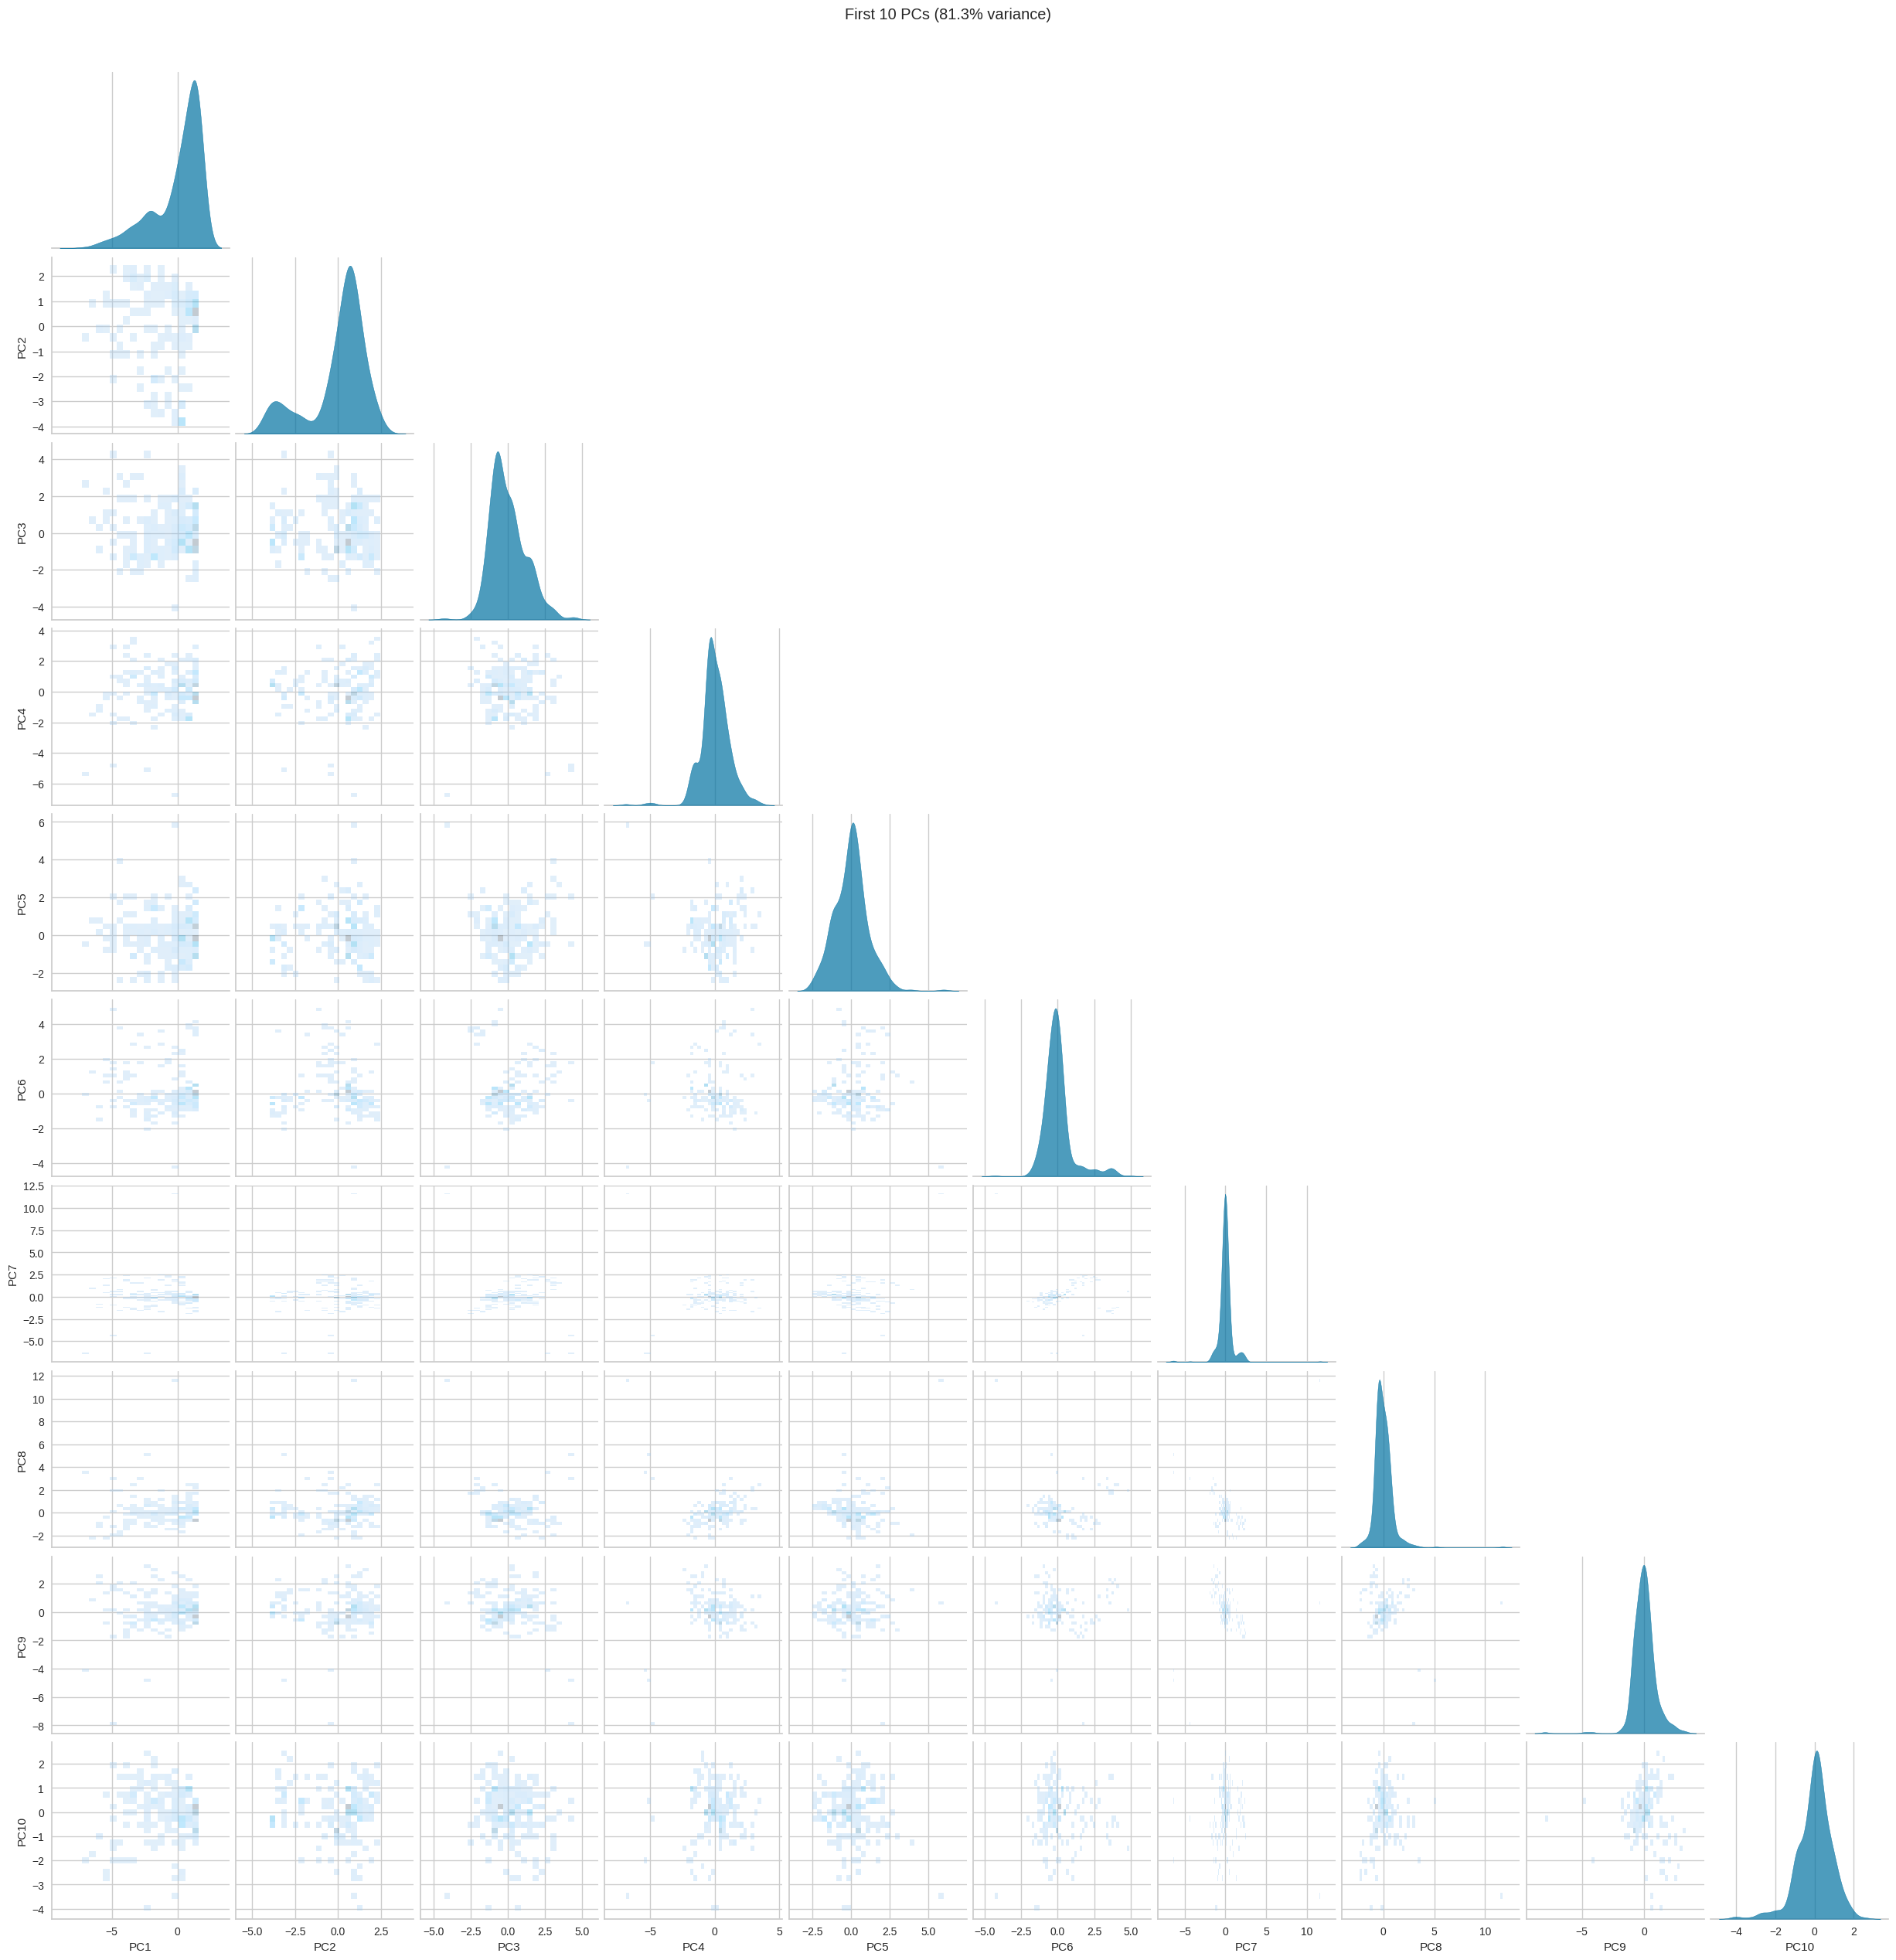

In [28]:
transformed = model.transform(color_data_normalized)

n_pcs = 10
pc_cols = [f'PC{j+1}' for j in range(n_pcs)]
pca_df = pd.DataFrame(transformed[:, :n_pcs], columns=pc_cols)

sns.pairplot(pca_df, kind='hist', diag_kind='kde', corner=True,
    plot_kws={'alpha': 0.3},
    diag_kws={'alpha': 0.7}
)
plt.suptitle(f'First {n_pcs} PCs ({round(np.cumsum(model.explained_variance_ratio_)[:n_pcs][-1]*100, 1)}% variance)', y=1.02)
plt.show()

PC1 and PC2 show the clearest structure with a visible bimodal split in PC1's KDE, which probably captures the early vs late era shift in Bob Ross's palette. PC2 also has a group pulling down to -4 suggesting another distinct subgroup. By PC5-PC6 the scatter plots start compressing and the KDEs get much narrower. PC7 and PC8 are basically just a spike at zero with a few extreme outliers, and PC9-PC10 don't add much either. So even though we need 10 components for 80% variance, the first 3-4 are doing most of the meaningful separation.

## 5. Themes and Seasons

Checking if the core vs specialty split holds across eras and painting subjects.

In [29]:
# Usage in early vs late seasons
early = df[df['season'] <= 10]
late = df[df['season'] >= 21]

print("Early seasons (1-10):")
print(f"- Avg colors: {round(early['num_colors'].mean(), 2)}")
print(f"- Dark Sienna usage: {round(early['Dark_Sienna'].mean() * 100, 2)}%")
print(f"- Burnt Umber usage: {round(early['Burnt_Umber'].mean() * 100, 2)}%")

print("\nLate seasons (21-31):")
print(f"- Avg colors: {round(late['num_colors'].mean(), 2)}")
print(f"- Dark Sienna usage: {round(late['Dark_Sienna'].mean() * 100, 2)}%")
print(f"- Burnt Umber usage: {round(late['Burnt_Umber'].mean() * 100, 2)}%")

Early seasons (1-10):
- Avg colors: 9.92
- Dark Sienna usage: 36.15%
- Burnt Umber usage: 42.31%

Late seasons (21-31):
- Avg colors: 10.83
- Dark Sienna usage: 81.12%
- Burnt Umber usage: 0.0%


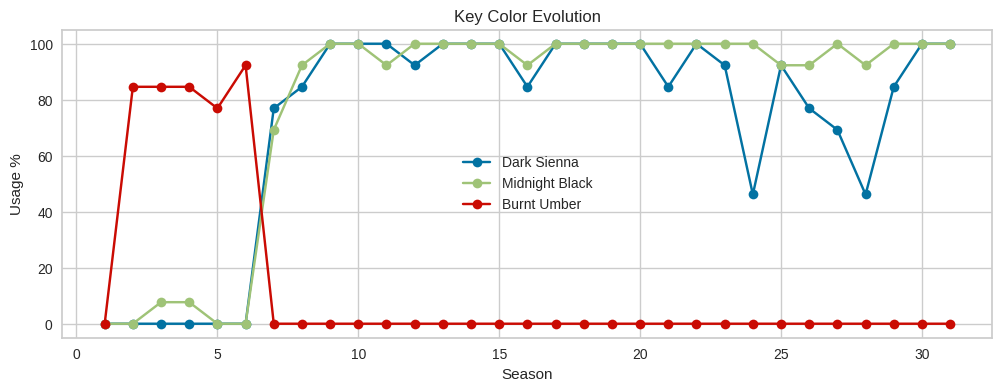

In [30]:
# Plot key color shifts over seasons
key_colors = ['Dark_Sienna', 'Midnight_Black', 'Burnt_Umber']

plt.figure(figsize=(12, 4))
for color in key_colors:
    usage = df.groupby('season')[color].mean() * 100
    plt.plot(usage.index, usage.values, marker='o', label=color.replace('_', ' '))

plt.xlabel('Season')
plt.ylabel('Usage %')
plt.title('Key Color Evolution')
plt.legend()
plt.show()

Burnt Umber basically disappeared while Dark Sienna and Midnight Black went from rarely used to nearly universal. This means some colors in the "transitional" cluster are there because they were core in one era but not the other.

In [31]:
# Compare winter vs non-winter
print("Color usage: Winter vs Non-Winter paintings")
winter = df[df['theme_winter']][color_cols].mean()
not_winter = df[~df['theme_winter']][color_cols].mean()

for color in color_cols:
    diff = winter[color] - not_winter[color]
    if abs(diff) > 0.15:
        print(f"  {color}: winter {round(winter[color]*100)}%, other {round(not_winter[color]*100)}%, diff {round(diff*100)}%")

Color usage: Winter vs Non-Winter paintings
  Black_Gesso: winter 11%, other 27%, diff -17%
  Bright_Red: winter 45%, other 85%, diff -41%
  Cadmium_Yellow: winter 38%, other 94%, diff -56%
  Indian_Yellow: winter 27%, other 80%, diff -53%
  Phthalo_Green: winter 11%, other 32%, diff -21%
  Sap_Green: winter 20%, other 85%, diff -65%
  Yellow_Ochre: winter 39%, other 88%, diff -49%


In [32]:
# Same for mountain paintings
print("Color usage: Mountain vs Non-Mountain paintings")
mountain = df[df['theme_mountain']][color_cols].mean()
not_mountain = df[~df['theme_mountain']][color_cols].mean()

for color in color_cols:
    diff = mountain[color] - not_mountain[color]
    if abs(diff) > 0.10:
        print(f"  {color}: mountain {round(mountain[color]*100)}%, other {round(not_mountain[color]*100)}%, diff {round(diff*100)}%")

Color usage: Mountain vs Non-Mountain paintings
  Black_Gesso: mountain 10%, other 28%, diff -18%
  Cadmium_Yellow: mountain 95%, other 84%, diff 11%
  Indian_Yellow: mountain 82%, other 71%, diff 12%
  Phthalo_Blue: mountain 89%, other 79%, diff 10%
  Phthalo_Green: mountain 39%, other 27%, diff 12%
  Prussian_Blue: mountain 82%, other 62%, diff 20%
  Sap_Green: mountain 92%, other 73%, diff 19%
  Yellow_Ochre: mountain 90%, other 79%, diff 11%


Comparing the output above, winter paintings have noticeably lower usage of greens (Sap Green, Phthalo Green) and yellows (Cadmium Yellow, Indian Yellow) compared to non-winter paintings. Mountain paintings show smaller differences but still lean heavier on blues. This suggests the core vs specialty split isn't universal, it depends on what Bob Ross was painting.

## 6. Summary

Clustering with K=8 on the transposed color matrix split the 18 colors into groups that go beyond just high/medium/low. For example Dark Sienna and Midnight Black ended up together which makes sense given their 0.78 correlation in the heatmap. The specialty colors that barely show up got isolated into their own clusters.

PCA took 10 components to reach 80% variance so there's a lot of independent variation going on. The loadings mostly highlight the mid-range colors since Titanium White is in everything and Indian Red is in almost nothing, neither really moves the needle.

The seasonal and theme analysis complicates the idea of a fixed "core" set. Burnt Umber went from common to basically gone while Dark Sienna did the opposite. Winter paintings drop greens and yellows compared to non-winter. So core vs specialty depends on the era and subject matter, not just overall frequency.

For something like a paint starter kit you'd pick from the high-usage cluster but adjust based on what someone wants to paint. For a streaming platform the mid-range colors are more useful for recommending episodes since the universal ones don't differentiate anything.

## Appendix: AI Usage

**Chat link:** https://chatgpt.com/share/698a99ac-0b78-8001-978a-94c02dc3e8cf

I used AI while working through this analysis. The linked chat shows the main back-and-forth. Two spots where it made a difference:

- **The transpose idea (Section 3):** I knew I wanted to group colors not paintings, but I wasn't sure how to set up the data for that. AI suggested transposing the matrix so colors become the rows. From there I just ran the same clustering steps from class.
- **Working through normalization results (Section 3.1):** When the first clustering attempt just sorted colors by frequency I talked it out with AI to figure out why, which connected back to the population scaling issue from the housing example.

Everything else follows the class notebooks and slides. The coding, visualizations, and interpretation are mine.